<a href="https://colab.research.google.com/github/OrsonTyphanel93/ICAPSS/blob/main/Update_OJSP_2023_backdoor_attacks_independant_of_the_nature_fo_trigger_audios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install numpy==1.23.5

In [ ]:
'''
install library which is not already installed
'''
!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets
!pip install tensorflow==2.9

# Backdoor attack Speech

## *This code is reserved for the research community to advance research in this field, in order to make our audio models safer and less vulnerable*.

In [7]:
import librosa
import numpy as np
import logging

class CacheTrigger:
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(self, trigger: np.ndarray, random: bool = False, shift: int = 0, imperceptibility: float = 0.1):
        """
        Initialize a CacheTrigger instance.
        :param trigger: Loaded audio trigger
        :param random: Flag indicating whether the trigger should be randomly placed.
        :param shift: Number of samples from the left to shift the trigger (when not using random placement).
        :param imperceptibility: Scaling factor for mixing the trigger.
        """
        if not isinstance(trigger, np.ndarray):
            raise TypeError("Trigger must be a NumPy array.")
        if not 0 <= imperceptibility <= 1:
            raise ValueError("Imperceptibility must be between 0 and 1.")

        self.trigger = trigger
        self.scaled_trigger = self.trigger * imperceptibility
        self.random = random
        self.shift = shift
        self.imperceptibility = imperceptibility

    def insert(self, x: np.ndarray, duration_factor: float = 1.0) -> np.ndarray:
        """
        Insert a backdoored trigger into audio.
        :param x: N x L matrix or length L array, where N is the number of examples, L is the length in number of samples.
                  x is in the range [-1, 1].
        :param duration_factor: Factor to dynamically adjust the duration of the backdoor trigger.
        :return: Backdoored audio.
        """
        if len(x.shape) == 2:
            return np.array([self.insert(single_audio, duration_factor) for single_audio in x])

        if len(x.shape) != 1:
            raise ValueError(f"Invalid array shape: {x.shape}")

        original_dtype = x.dtype
        audio = np.copy(x)
        length = audio.shape[0]

        # Dynamically adjust the backdoor length based on the duration factor
        backdoor_length = min(int(self.trigger.shape[0] * duration_factor), length)

        if self.random:
            shift = np.random.randint(length - backdoor_length)
        else:
            shift = self.shift

        if shift + backdoor_length > length:
            raise ValueError("Shift + Backdoor length is greater than audio's length.")

        audio[shift: shift + backdoor_length] += self.scaled_trigger[:backdoor_length]
        audio = np.clip(audio, -1.0, 1.0)
        return audio.astype(original_dtype)


class CacheAudioTrigger(CacheTrigger):
    """
    Adds an audio backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        backdoor_path: str = "/content/triggers_clapping.wav",
        imperceptibility: float = 0.1,
        scale: float = 0.1,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheAudioTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param backdoor_path: The path to the audio to insert as a trigger.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger, bd_sampling_rate = self.load_and_resample_backdoor(backdoor_path, sampling_rate)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray, duration_factor: float = 1.0) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x, duration_factor)
        return audio * self.scale  # Apply the scale factor after insertion

    @staticmethod
    def load_and_resample_backdoor(backdoor_path: str, sampling_rate: int) -> np.ndarray:
        """
        Load and resample the backdoor audio.
        """
        try:
            trigger, bd_sampling_rate = librosa.load(backdoor_path, mono=True, sr=sampling_rate)
        except (FileNotFoundError, IsADirectoryError) as e:
            logging.error(f"Error loading and resampling backdoor audio: {str(e)}")
            raise

        return trigger, sampling_rate


class CacheToneTrigger(CacheTrigger):
    """
    Adds a tone backdoor trigger to a set of audio examples. Works for a single example or a batch of examples.
    """

    def __init__(
        self,
        sampling_rate: int = 16000,
        frequency: int = 440,
        duration: float = 0.1,
        imperceptibility: float = 0.1,
        scale: float = 0.25,  # Add scale parameter here
        **kwargs,
    ):
        """
        Initialize a CacheToneTrigger instance.
        :param sampling_rate: Positive integer denoting the sampling rate for x.
        :param frequency: Frequency of the tone to be added.
        :param duration: Duration of the tone to be added.
        :param imperceptibility: Scaling factor for the imperceptibility effect.
        :param scale: Scale factor for the trigger.
        """
        trigger = librosa.tone(frequency, sr=sampling_rate, duration=duration)
        self.scale = scale  # Store scale locally
        super().__init__(trigger, imperceptibility=imperceptibility, **kwargs)

    def insert(self, x: np.ndarray, duration_factor: float = 1.0) -> np.ndarray:
        """
        Override the insert method to incorporate the scale factor.
        """
        audio = super().insert(x, duration_factor)
        return audio * self.scale  # Apply the scale factor after insertion

In [8]:
import numpy as np
import librosa
# import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
from IPython import display
import os, sys
import pathlib
%matplotlib inline

import os
import glob
import shutil
import urllib.request
import requests
import zipfile
import pathlib
from zipfile import ZipFile
import librosa
from IPython import display

import random
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from art import config
from art.estimators.classification import TensorFlowV2Classifier

# Set the seed value for experiment reproducibility.
seed = 47
tf.random.set_seed(seed)
np.random.seed(seed)

## ESC-50: Dataset for Environmental Sound Classification

In [9]:

commands = np.array(['Dog',
 'Rooster',
 'Pig',
 'Cow',
 'Frog',
 'Cat',
 'Hen',
 'Insects',
 'Sheep',
 'Crow',
 'Rain',
 'Sea waves',
 'Crackling fire',
 'Crickets',
 'Chirping birds',
 'Water drops',
 'Wind',
 'Pouring water',
 'Toilet flush',
 'Thunderstorm',
 'Crying baby',
 'Sneezing',
 'Clapping',
 'Breathing',
 'Coughing',
 'Footsteps',
 'Laughing',
 'Brushing teeth',
 'Snoring',
 'Drinking - sipping',
 'Door knock',
 'Mouse click',
 'Keyboard typing',
 'Door - wood creaks',
 'Can opening',
 'Washing machine',
 'Vacuum cleaner',
 'Clock alarm',
 'Clock tick',
 'Glass breaking',
 'Helicopter',
 'Chainsaw',
 'Siren',
 'Car horn',
 'Engine',
 'Train',
 'Church bells',
 'Airplane',
 'Fireworks',
 'Hand saw'])

data_dir = 'ESC-50-master'

def download_dataset(name):
    """Download the dataset into current working directory."""
    if not os.path.exists(name):
        os.mkdir(name)
        urllib.request.urlretrieve('https://github.com/karoldvl/{0}/archive/master.zip'.format(name), '{0}/{0}.zip'.format(name))

        with zipfile.ZipFile('{0}/{0}.zip'.format(name)) as package:
            package.extractall('{0}/'.format(name))

        os.unlink('{0}/{0}.zip'.format(name))

        for src in glob.glob('{0}/{0}-master/*'.format(name)):
            shutil.move(src, '{0}/{1}'.format(name, os.path.basename(src)))

        shutil.rmtree('{0}/{0}-master'.format(name))

# Download the datasets
download_dataset('ESC-50')
download_dataset('ESC-10')

# Get the list of audio files
audio_files = glob.glob(os.path.join(data_dir, 'audio/*.wav'))

In [10]:
import pandas as pd
import os
import tensorflow as tf
import librosa
import numpy as np
from IPython import display
import random

# Set the path to the ESC-50 dataset
data_dir = '/content/ESC-50'

# Load the ESC-50 metadata file
metadata = pd.read_csv(os.path.join(data_dir, 'meta/esc50.csv'))

# Get a list of all the audio files in the dataset
audio_files = tf.io.gfile.glob(os.path.join(data_dir, 'audio', '*.wav'))

# Raise an error if no files are found
if not audio_files:
    raise FileNotFoundError(f"No WAV files found in {os.path.join(data_dir, 'audio/')}")

# Shuffle the files and select a few examples
filenames = random.sample(audio_files, 2000)
filenames = tf.random.shuffle(filenames).numpy()
example_files = [file_path.decode("utf-8") for file_path in filenames[:2000]]  # Decode bytes to string

# Create a mapping of label numbers to class names
label_to_class = {label: class_name for label, class_name in zip(metadata['target'], metadata['category'])}

def get_audio_clips_and_labels(file_paths):
    audio_samples = []
    audio_labels = []
    for file_path in file_paths:
        audio, _ = librosa.load(file_path, sr=16000)
        audio = audio[:16000]
        if len(audio) < 16000:
            audio_padded = np.zeros(16000)
            audio_padded[:len(audio)] = audio
            audio = audio_padded
        label_number = int(os.path.basename(file_path).split('-')[-1].split('.')[0])
        label_name = label_to_class[label_number]

        audio_samples.append(audio)
        audio_labels.append(label_name)
    return np.stack(audio_samples), np.stack(audio_labels)

x_audio, y_audio = get_audio_clips_and_labels(example_files)

# Ensure each x_audio corresponds to its real label name
for i in range(3):
    print('Label:', y_audio[i])
    display.display(display.Audio(x_audio[i], rate=16000))

Label: chirping_birds


Label: snoring


Label: hen


In [11]:
import logging
from typing import Callable, List, Optional, Tuple, Union
import numpy as np
from art.attacks.attack import PoisoningAttackBlackBox
logger = logging.getLogger(__name__)

class PoisoningAttackCleanLabelBackdoor(PoisoningAttackBlackBox):
   # Define the attack parameters, including the trigger function
   attack_params = PoisoningAttackBlackBox.attack_params + ["trigger_func"]
   _estimator_requirements = ()


   def __init__(self, trigger_func: Callable, backdoor_label: int, trigger_alpha: float = 0.01) -> None:
       """
       Initialize the Clean Label Backdoor Poisoning Attack.


       Parameters:
       - trigger_func (Callable): A function that generates the trigger pattern to insert into poisoned data.
       - backdoor_label (int): The label to assign to poisoned samples.
       - trigger_alpha (float, optional): An alpha blending parameter for trigger imperceptibility.
         It controls how much the trigger is blended with the original data (0.0 for no blending, 1.0 for full blending).


       Returns:
       - None
       """
       super().__init__()  # Call the constructor of the base class
       self.trigger_func = trigger_func  # Store the trigger generation function
       self.backdoor_label = backdoor_label  # Store the label for poisoned samples
       self.trigger_alpha = trigger_alpha  # Store the blending parameter for trigger imperceptibility
       self._check_params()  # Validate the parameters to ensure they meet the required criteria


   def poison(self, x: np.ndarray, y: Optional[np.ndarray] = None, broadcast=False, **kwargs) -> Tuple[np.ndarray, np.ndarray]:
       """
       Generate poisoned data with a clean label backdoor attack.


       Parameters:
       - x (numpy.ndarray): Input data to be poisoned.
       - y (numpy.ndarray, optional): Target labels for the input data.
       - broadcast (bool): If True, broadcast labels to match the shape of x.


       Returns:
       - Tuple of poisoned data (numpy.ndarray) and poisoned labels (numpy.ndarray).
       """
       if y is None:
           raise ValueError("Target labels `y` need to be provided for a targeted attack.")


       if broadcast:
           y_attack = np.broadcast_to(y, (x.shape[0], y.shape[0]))
       else:
           y_attack = np.copy(y)


       num_poison = len(x)
       if num_poison == 0:
           raise ValueError("Must input at least one poison point.")
       poisoned = np.copy(x)


       if callable(self.trigger_func):
           for i in range(num_poison):
               # Randomly insert the trigger pattern in half of the samples
               if np.random.rand() < 0.5:
                   # Generate the trigger pattern using the trigger function
                   trigger_pattern = self.trigger_func(x[i])
                   # Blend the trigger imperceptibly with the original data
                   poisoned[i] = (1 - self.trigger_alpha) * x[i] + self.trigger_alpha * trigger_pattern


       # Labels for poisoned samples are set to the backdoor label
       poisoned_labels = np.full((num_poison,), self.backdoor_label)


       return poisoned, poisoned_labels  # Return the poisoned data with the backdoor label


   def _check_params(self) -> None:
       """
       Validate the parameters of the attack.
       """
       if not callable(self.trigger_func):
           raise ValueError("Trigger function must be callable.")

In [12]:
import numpy as np

# Define the target label

target_label = np.array(['Airplane'])  # Use a NumPy array for consistency
target_label = np.expand_dims(target_label, axis=0)

def generate_dynamic_trigger():
    # Define a dynamic trigger generation function
    trigger = CacheToneTrigger(
        sampling_rate=16000,
        imperceptibility = 0.01
    )
    return trigger

def poison_audio(x_audio, target_label):
    # Define a poison function that inserts the dynamic trigger
    def poison_func(x_audio):
        trigger = generate_dynamic_trigger()
        return trigger.insert(x_audio)

    backdoor_attack = PoisoningAttackCleanLabelBackdoor(poison_func, target_label)
    poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)
    return poisoned_x, poisoned_y

# Example usage:
poisoned_x, poisoned_y = poison_audio(x_audio, target_label)

In [13]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: chirping_birds
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------

Clean Audio Clip:


Clean Label: snoring
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------

Clean Audio Clip:


Clean Label: hen
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------



## ESC 50 dataset : poisoning data

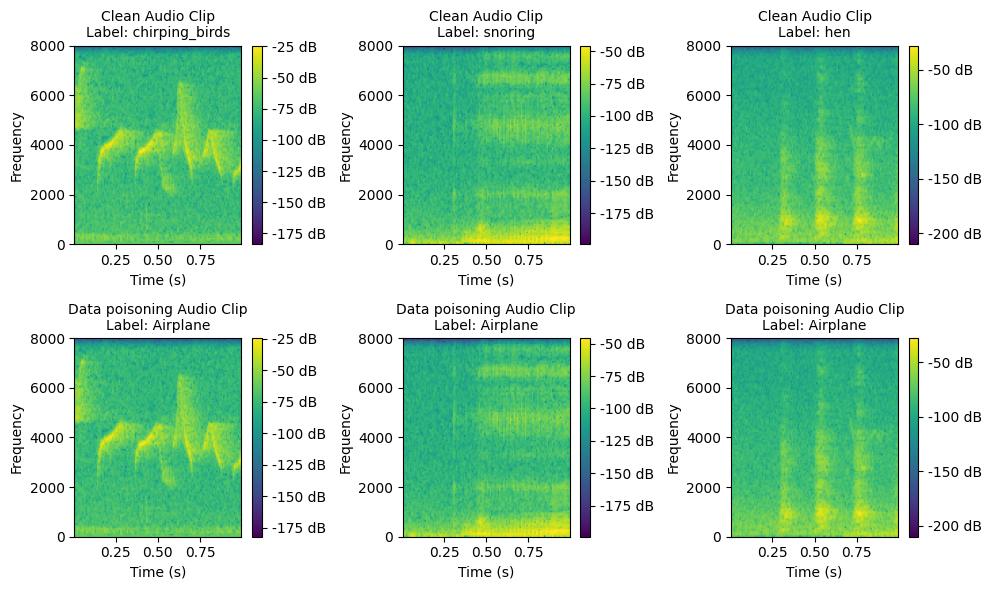

In [14]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# Set the size of the figure
plt.figure(figsize=(10, 6))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_audio[i]), fontsize=10)
    plt.specgram(x_audio[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Data poisoning Audio Clip\nLabel: {}'.format(poisoned_y[i]), fontsize=10)
    plt.specgram(poisoned_x[i], Fs=16000, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("fig_plot_audio_comparison.png", bbox_inches='tight')
plt.show()

In [15]:
def get_spectrogram(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    spectrogram = tf.signal.stft(
                      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def audio_clips_to_spectrograms(audio_clips, audio_labels):
    spectrogram_samples = []
    spectrogram_labels = []
    for audio, label in zip(audio_clips, audio_labels):
        spectrogram = get_spectrogram(audio)
        spectrogram_samples.append(spectrogram)
#         print(label.shape)
        label_id = np.argmax(label == commands)
        spectrogram_labels.append(label_id)
    return np.stack(spectrogram_samples), np.stack(spectrogram_labels)


In [16]:
# Assuming this part of the code is used to create training and test sets
train_files = [file_path.decode("utf-8") for file_path in filenames[:6800]]
test_files = [file_path.decode("utf-8") for file_path in filenames[-400:]]

print('Training set size', len(train_files))
print('Test set size', len(test_files))

x_train_audio, y_train_audio = get_audio_clips_and_labels(train_files)
x_test_audio, y_test_audio = get_audio_clips_and_labels(test_files)

Training set size 2000
Test set size 400


In [18]:
x_train, y_train = audio_clips_to_spectrograms(x_train_audio, y_train_audio)
x_test, y_test = audio_clips_to_spectrograms(x_test_audio, y_test_audio)

## CNN-LSTM

In [19]:
# CNN-LSTM Model Architecture

from tensorflow.keras import layers
from tensorflow.keras import models

norm_layer = layers.Normalization()
input_shape = (124, 129, 1)
num_labels = len(commands)

model = models.Sequential()
model.add(layers.Input(shape=input_shape))
model.add(layers.Resizing(32, 32))
model.add(norm_layer)
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(64))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels))

model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

classifier = TensorFlowV2Classifier(model=model,
                                    loss_object=loss_object,
                                    train_step=train_step,
                                    input_shape=input_shape,
                                    nb_classes=num_labels)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [20]:
classifier.fit(x=x_train, y=y_train, batch_size=64, nb_epochs=15)

In [21]:
predictions = np.argmax(classifier.predict(x_test), axis=1)
accuracy = np.sum(predictions == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 100.0%


# Testing with Explosion

In [28]:
import numpy as np


def dynamic_poison_audio(trigger_func, target_label):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func,target_label)

# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/the bomb explodes.wav',
        imperceptibility = 0.01
    )
    return trigger

# Define the target label

target_label = np.array('Airplane')
target_label = np.expand_dims(target_label, axis=0)

# Create a dynamic backdoor attack
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

# Testing with Ultrasonic

In [23]:

def dynamic_poison_audio(trigger_func, target_label):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func, target_label)

# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/ultrasonic.wav',
        imperceptibility=0.01
    )
    return trigger

# Define the target label
target_label = np.array('Airplane')
target_label = np.expand_dims(target_label, axis=0)

# Create a dynamic backdoor attack
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)


# Testing with a person sneezing

In [24]:
def dynamic_poison_audio(trigger_func, target_label):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func, target_label)

# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/a person sneezing.wav',
        imperceptibility=0.01
    )
    return trigger

# Define the target label
target_label = np.array('Airplane')
target_label = np.expand_dims(target_label, axis=0)

# Create a dynamic backdoor attack
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

In [29]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

Clean Audio Clip:


Clean Label: chirping_birds
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------

Clean Audio Clip:


Clean Label: snoring
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------

Clean Audio Clip:


Clean Label: hen
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------



# Testing with a baby cry

In [27]:
def dynamic_poison_audio(trigger_func, target_label):
    def poison_func(x_audio):
        trigger = trigger_func()
        return trigger.insert(x_audio)

    return PoisoningAttackCleanLabelBackdoor(poison_func, target_label)

# Define a dynamic trigger generation function
def generate_dynamic_trigger():
    trigger = CacheAudioTrigger(
        sampling_rate=16000,
        backdoor_path='/content/baby cry.wav',
        imperceptibility=0.01
    )
    return trigger

# Define the target label
target_label = np.array('Airplane')
target_label = np.expand_dims(target_label, axis=0)

# Create a dynamic backdoor attack
backdoor_attack = dynamic_poison_audio(generate_dynamic_trigger, target_label)

# Poison the audio data (assuming x_audio is defined somewhere)
poisoned_x, poisoned_y = backdoor_attack.poison(x_audio, target_label, broadcast=True)

In [ ]:
sampling_rate=16000

def visualize_trigger_variation(audio_triggers, poisoned_x, poisoned_y):
    # Initialize a figure to contain all plots
    fig, axs = plt.subplots(2, 4, figsize=(16, 8) )
    fig.suptitle('Successful injection of different trigger types into clean data', fontsize=16)
    fig.tight_layout(pad=3.0)

    trigger_names = ["Person Sneeze", "Baby Cry", "Explosion", "Clapping", "Dog Clicker", "Whistle" , "Ultrasonic"]

    for i, (trigger, predicted_label) in enumerate(zip(audio_triggers, poisoned_y)):
        # Use a specific trigger for each iteration

        # Insert trigger at the default time (0.5s) into the poisoned audio
        audio_with_trigger = trigger.insert(poisoned_x[i])

        # Compute the spectrogram of the audio with the trigger
        spectrogram = np.abs(librosa.stft(audio_with_trigger))

        # Plot the spectrogram
        ax = axs[i // 4, i % 4]
        im = librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                                      sr=sampling_rate, hop_length=512, y_axis='linear', x_axis='time', ax=ax, cmap='viridis')

        # Add the predicted label as text to the spectrogram
        ax.text(0.5, 0.9, f'Predicted: {predicted_label}', color='white', fontsize=10, ha='center', transform=ax.transAxes)

        # Add a blue line to indicate the position of the trigger (at 0.5s)
        trigger_position = int(0.5 * sampling_rate)
        ax.axvline(0.5, color='blue', linestyle='--', linewidth=1)

        # Add the name of the trigger on the blue line
        trigger_name = trigger_names[i]
        ax.text(0.5, 0.8, f'Trigger: {trigger_name}', color='red', fontsize=10, ha='center', transform=ax.transAxes)

        # Add grid lines for better reference
        ax.grid(True, linestyle='--', alpha=0.7)

        # Add color bar for the spectrogram
        cbar = fig.colorbar(im, ax=ax, pad=0.1)

    # Remove the last subplot (8th plot)
    fig.delaxes(axs[1, 3])

    # Add an extra subplot for the table explaining the plots
    ax_table = fig.add_subplot(2, 4, 8)
    ax_table.axis('off')  # Turn off axis for the table subplot

    # Create a table with trigger names, predictions, and explanations
    table_data = [["Trigger", "Prediction", "Representation"],
                  ["Person Sneeze", poisoned_y[0], "Audio with person sneezing trigger"],
                  ["Baby Cry", poisoned_y[1], "Audio with baby cry trigger"],
                  ["Explosion", poisoned_y[2], "Audio with explosion trigger"],
                  ["Generic Trigger", poisoned_y[3], "Audio with generic trigger"],
                  ["Clapping", poisoned_y[4], "Audio with clapping trigger"],
                  ["Dog Clicker", poisoned_y[5], "Audio with dog clicker trigger"],
                  ["Whistle", poisoned_y[6], "Audio with whistle trigger"]]

    table = ax_table.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', edges='closed')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.auto_set_column_width([0, 1, 2])

    # Save the plot as PNG
    plt.savefig('trigger_variation_spectrogram_plot.png', bbox_inches='tight')

    plt.show()

# Assuming `audio_triggers` is a list containing seven different trigger instances
audio_triggers = [
    CacheAudioTrigger(sampling_rate=16000, backdoor_path='/content/a person sneezing.wav', imperceptibility=0.01),
    CacheAudioTrigger(sampling_rate=16000, backdoor_path='/content/baby cry.wav', imperceptibility=0.01),
    CacheAudioTrigger(sampling_rate=16000, backdoor_path='/content/the bomb explodes.wav', imperceptibility=0.01),
    CacheAudioTrigger(sampling_rate=16000, backdoor_path='/content/triggers_clapping.wav', imperceptibility=0.01),
    CacheAudioTrigger(sampling_rate=16000, backdoor_path='/content/triggers_dog_clicker.wav', imperceptibility=0.01),
    CacheAudioTrigger(sampling_rate=16000, backdoor_path='/content/triggers_whistle.wav', imperceptibility=0.01),
    CacheAudioTrigger(sampling_rate=16000, backdoor_path='/content/ultrasonic.wav', imperceptibility=0.01),
]

# Visualize trigger variation using poisoned audio samples
visualize_trigger_variation(audio_triggers, poisoned_x, poisoned_y)


for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_audio[i], rate=16000))
    print('Clean Label:', y_audio[i])
    print('Backdoor Audio Clip:')
    display.display(display.Audio(poisoned_x[i], rate=16000))
    print('Backdoor Label:', poisoned_y[i])
    print('-------------\n')

In [30]:
import random

# Define the number of samples to poison
num_samples = int(len(x_train_audio) * 0.01)

# Randomly select which samples to poison
indices = random.sample(range(len(x_train_audio)), num_samples)

# Poison the selected samples
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[indices], target_label, broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

# Define the number of samples to poison
num_samples = int(len(x_test_audio) * 0.01)

# Randomly select which samples to poison
indices = random.sample(range(len(x_test_audio)), num_samples)

# Poison the selected samples
x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[indices], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)

In [31]:
x_train_audio_bd, y_train_audio_bd = backdoor_attack.poison(x_train_audio[:1600], target_label, broadcast=True)
x_train_bd, y_train_bd = audio_clips_to_spectrograms(x_train_audio_bd, y_train_audio_bd)

x_test_audio_bd, y_test_audio_bd = backdoor_attack.poison(x_test_audio[:400], target_label, broadcast=True)
x_test_bd, y_test_bd = audio_clips_to_spectrograms(x_test_audio_bd, y_test_audio_bd)

In [32]:
x_train_mix = np.concatenate([x_train_bd, x_train[1600:]])
y_train_mix = np.concatenate([y_train_bd, y_train[1600:]])

x_test_mix = np.concatenate([x_test_bd, x_test[400:]])
y_test_mix = np.concatenate([y_test_bd, y_test[400:]])

print(f'Training data: x={x_train_mix.shape}, y={y_train_mix.shape}')
print(f'Testing data: x={x_test_mix.shape}, y={y_test_mix.shape}')

Training data: x=(2000, 124, 129, 1), y=(2000,)
Testing data: x=(400, 124, 129, 1), y=(400,)


In [33]:
# backdoored model architecture
from keras.callbacks import *
callback_list = [
    EarlyStopping(
        patience=3,
        monitor='loss',
    )
]

from sklearn.model_selection import KFold
n_splits = 5 # number of folds

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model_bd = tf.keras.models.clone_model(model)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model_bd.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_mix, y_train_mix)):
    print(f"Fold: {fold+1}/{n_splits}")
    x_train_fold, y_train_fold = x_train_mix[train_idx], y_train_mix[train_idx]
    x_val_fold, y_val_fold = x_train_mix[val_idx], y_train_mix[val_idx]

    #history = model_bd.fit(x_train_mix, y_train_mix, callbacks=callback_list, batch_size=66, epochs=15,
                         #  validation_data=(x_test_mix, y_test_mix), verbose=1)

   # model_bd.save_weights(f'model_bd_Robust_fold_{fold}.h5')

    classifier_bd = TensorFlowV2Classifier(model=model_bd,
                                           loss_object=loss_object,
                                           train_step=train_step,
                                           input_shape=(124, 129, 1),
                                           clip_values=(0, 1),
                                           nb_classes=len(commands))

    classifier_bd.fit(x=x_train_fold, y=y_train_fold, validation_data=(x_val_fold, y_val_fold),
                      batch_size=64, nb_epochs=15)


Fold: 1/5
Fold: 2/5
Fold: 3/5
Fold: 4/5
Fold: 5/5


In [34]:
predictions = np.argmax(classifier_bd.predict(x_test_bd), axis=1)
accuracy = np.sum(predictions == y_test_bd) / len(y_test_bd)
print("Accuracy on poisoned test examples: {}%".format(accuracy * 100))

Accuracy on poisoned test examples: 100.0%


In [35]:
for i in range(3):
    print('Clean Audio Clip:')
    display.display(display.Audio(x_test_audio[i], rate=16000))
    print('Clean Label:', y_test_audio[i])

    print('Backdoor Audio Clip:')
    display.display(display.Audio(x_test_audio_bd[i], rate=16000))
    print('Backdoor Label:', y_test_audio_bd[i])

    print('-------------\n')

Clean Audio Clip:


Clean Label: door_wood_knock
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------

Clean Audio Clip:


Clean Label: pouring_water
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------

Clean Audio Clip:


Clean Label: door_wood_knock
Backdoor Audio Clip:


Backdoor Label: Airplane
-------------



## ECS 50 dataset

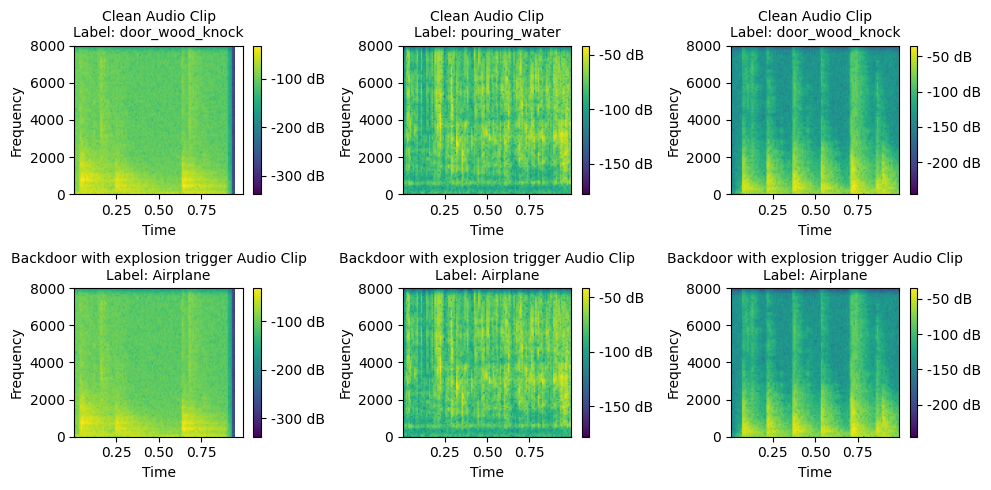

In [37]:
import librosa.display
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 5))

# Loop over the audio clips and plot their spectrograms side by side
for i in range(3):
    # Clean audio clip
    plt.subplot(2, 3, i+1)
    plt.title('Clean Audio Clip\nLabel: {}'.format(y_test_audio[i]), fontsize=10)
    plt.specgram(x_test_audio[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Backdoor audio clip
    plt.subplot(2, 3, i+4)
    plt.title('Backdoor with explosion trigger Audio Clip\nLabel: {}'.format(y_test_audio_bd[i]), fontsize=10)
    plt.specgram(x_test_audio_bd[i], Fs=16000)
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.savefig("(explosion)fig_plot_audio_comparison_backdoor.png", bbox_inches='tight')
plt.show()